# <h1 style="text-align: center; font-weight: bolder;">LAB 6</h1>


# <h2 style="text-align: center; font-weight: bolder;">SETUP</h2>


In [ ]:
# instalación de dependencias
!pip install torch torchaudio mirdata tqdm matplotlib umap-learn scikit-learn auraloss codecarbon pandas soundfile
# imports generales
import os
import sys
import zipfile
import random
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import soundfile as sf
from torch.utils.data import Dataset, DataLoader

import mirdata
from tqdm import trange
import matplotlib.pyplot as plt

from codecarbon import EmissionsTracker

from pathlib import Path
import pandas as pd

# configuración de dispositivo (CUDA / MPS / CPU)
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print("Device:", device)

# configuración de hilos CPU (acelera dataloader y STFT si quedan en CPU)
import os
torch.set_num_threads(max(1, (os.cpu_count() or 4) - 1))

# seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == "cuda":
    torch.cuda.manual_seed_all(SEED)

# parámetros de audio
SAMPLE_RATE = 16000
TARGET_LENGTH = 16000  # como en el lab 5 / ejemplo 1s
BATCH_SIZE = 64
N_EPOCHS = 50

# placeholder para ruta de datos local (se fija en el fallback)
DATA_ROOT = None

Device: cpu


# <h2 style="text-align: center; font-weight: bolder;">DATA LOADING WITH MAGNATAGATUNE</h2>


Reutilizamos parcialmente el codigo del lab anterior

En lab 5 ya teniamos: 
- Mirdata initialize
- Un dataset
- Segmentación



In [22]:
# intento de carga con mirdata y fallback a versión local
USE_MIRDATA = False

try:
    # carga de datos con mirdata
    data_home = "/content/data/mtat"
    mtat = mirdata.initialize("magnatagatune", data_home=data_home)
    mtat.download()
    mtat.validate()

    # carga de tracks
    all_tracks_dict = mtat.load_tracks()
    all_tracks = list(all_tracks_dict.values())
    random.shuffle(all_tracks)

    n_total = len(all_tracks)
    n_train = int(0.8 * n_total)
    n_val = int(0.1 * n_total)

    train_tracks = all_tracks[:n_train]
    val_tracks   = all_tracks[n_train:n_train + n_val]
    test_tracks  = all_tracks[n_train + n_val:]

    USE_MIRDATA = True
    print("Usando MagnaTagATune vía mirdata.")
    print("Tamaños (train, val, test):", len(train_tracks), len(val_tracks), len(test_tracks))

except Exception as e:
    print("No fue posible inicializar MagnaTagATune con mirdata. Se usará la versión local.")
    print("Detalle del error:", e)

    # detección de data_dir igual que en el Lab 5
    IN_COLAB = "google.colab" in sys.modules

    if IN_COLAB:
        from google.colab import drive
        drive.mount("/content/drive")
        search_roots = [
            Path("/content/drive/MyDrive/datalab5"),
            Path("/content/drive/MyDrive"),
            Path("/content")
        ]
    else:
        search_roots = [
            Path.cwd(),
            Path.cwd().parent,
            Path.cwd().parent.parent
        ]

    data_path = None
    for root in search_roots:
        if root.exists():
            for p in root.rglob("annotations_final.csv"):
                data_path = p.parent
                break
        if data_path is not None:
            break

    if data_path is None:
        raise FileNotFoundError("No se encontró 'annotations_final.csv' en rutas conocidas")

    print("USING DATA DIR:", data_path)
    data_dir = str(data_path)

    # rutas a CSVs
    ann_path = os.path.join(data_dir, "annotations_final.csv")
    info_path = os.path.join(data_dir, "clip_info_final.csv")

    # lectura de metadatos
    df_ann = pd.read_csv(ann_path, sep="\t")
    df_info = pd.read_csv(info_path, sep="\t")

    # preparación de carpeta de audio (audio/000, audio/001, ...)
    audio_root = os.path.join(data_dir, "audio")
    os.makedirs(audio_root, exist_ok=True)

    full_zip = os.path.join(data_dir, "mp3_full.zip")
    if not os.path.exists(os.path.join(audio_root, "000")):
        with zipfile.ZipFile(full_zip, "r") as z:
            z.extractall(audio_root)

    # ids de clips
    all_ids = df_ann["clip_id"].values

    # opcional pero por tiempo de entrenamiento: limitar a un máximo de clips como en el lab 5
    max_tracks = 10000
    if len(all_ids) > max_tracks:
        all_ids = all_ids[:max_tracks]

    # mapeo clip_id -> ruta relativa mp3_path
    path_map = dict(zip(df_info["clip_id"], df_info["mp3_path"]))

    # split local 80/10/10
    all_ids = list(all_ids)
    random.shuffle(all_ids)

    n_total = len(all_ids)
    n_train = int(0.8 * n_total)
    n_val = int(0.1 * n_total)

    train_ids = all_ids[:n_train]
    val_ids   = all_ids[n_train:n_train + n_val]
    test_ids  = all_ids[n_train + n_val:]

    # construcción de DataFrames con columnas clip_id y mp3_path
    df_info_indexed = df_info.set_index("clip_id")

    def make_df(id_list):
        rows = []
        for cid in id_list:
            if cid in df_info_indexed.index:
                rows.append({
                    "clip_id": cid,
                    "mp3_path": df_info_indexed.loc[cid, "mp3_path"]
                })
        return pd.DataFrame(rows)

    train_df = make_df(train_ids)
    val_df   = make_df(val_ids)
    test_df  = make_df(test_ids)

    # fijar ruta global a carpeta de audio (audio_root)
    DATA_ROOT = Path(audio_root)

    print("Usando versión local de MagnaTagATune.")
    print("Tamaños (train, val, test):", len(train_df), len(val_df), len(test_df))
    print("DATA_ROOT:", DATA_ROOT)

No fue posible inicializar MagnaTagATune con mirdata. Se usará la versión local.
Detalle del error: Invalid dataset magnatagatune
USING DATA DIR: /Users/meco/Library/CloudStorage/OneDrive-Personal/Educación/UPF/Cursos/Machine Learning for Music/Labs/datalabs


[codecarbon INFO @ 04:35:35] Energy consumed for RAM : 0.000250 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 04:35:35] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 04:35:35] Energy consumed for All CPU : 0.000208 kWh
[codecarbon INFO @ 04:35:35] 0.000458 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 04:35:47] Energy consumed for RAM : 0.000775 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 04:35:47] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 04:35:47] Energy consumed for All CPU : 0.000646 kWh
[codecarbon INFO @ 04:35:47] 0.001421 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 04:35:50] Energy consumed for RAM : 0.000275 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 04:35:50] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 04:35:50] Energy consumed for All CPU : 0.0

Usando versión local de MagnaTagATune.
Tamaños (train, val, test): 8000 1000 1000
DATA_ROOT: /Users/meco/Library/CloudStorage/OneDrive-Personal/Educación/UPF/Cursos/Machine Learning for Music/Labs/datalabs/audio


Dataset para encoder

# <h2 style="text-align: center; font-weight: bolder;">AUTOENCODER BASELINE (MSE)</h2>


Autoencoder convolucional

In [23]:
# dataset para autoencoder (mirdata)
class MTATAutoencoderDatasetMirdata(Dataset):
    def __init__(self, tracks, split="train"):
        self.tracks = tracks
        self.split = split

    def __len__(self):
        return len(self.tracks)

    def __getitem__(self, idx):
        # carga de datos
        track = self.tracks[idx]
        audio, sr = track.audio

        # conversión a tensor
        audio = torch.tensor(audio, dtype=torch.float32)

        # conversion a mono
        if audio.ndim > 1:
            audio = audio.mean(dim=0)

        # resample
        if sr != SAMPLE_RATE:
            audio = torchaudio.functional.resample(
                audio.unsqueeze(0),
                orig_freq=sr,
                new_freq=SAMPLE_RATE
            ).squeeze(0)

        # tratamiento de audio largo (como seccion 2)
        audio = self._crop_or_pad(audio)

        return {"audio": audio}

    def _crop_or_pad(self, audio):
        length = audio.shape[-1]
        if length > TARGET_LENGTH:
            if self.split == "train":
                start = random.randint(0, length - TARGET_LENGTH)
            else:
                start = (length - TARGET_LENGTH) // 2
            audio = audio[start:start + TARGET_LENGTH]
        elif length < TARGET_LENGTH:
            pad = TARGET_LENGTH - length
            audio = F.pad(audio, (0, pad))
        return audio



# dataset para autoencoder (local: CSV + mp3)
class MTATAutoencoderDatasetLocal(Dataset):
    def __init__(self, df, split="train", data_root=None):
        self.df = df.reset_index(drop=True)
        self.split = split
        self.data_root = Path(data_root) if data_root is not None else None

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # carga de datos
        row = self.df.iloc[idx]
        mp3_rel = str(row["mp3_path"])

        # normalización de ruta (evita duplicar 'audio/audio/...')
        if mp3_rel.startswith("audio/"):
            mp3_rel = mp3_rel[len("audio/"):]

        audio_path = self.data_root / mp3_rel

        # lectura de audio (evita torchcodec/ffmpeg)
        audio_np, sr = sf.read(str(audio_path), always_2d=True)  # (T, C)

        # conversión a tensor (C, T)
        audio = torch.tensor(audio_np, dtype=torch.float32).T

        # conversion a mono
        if audio.size(0) > 1:
            audio = audio.mean(dim=0, keepdim=True)

        # resample
        if sr != SAMPLE_RATE:
            audio = torchaudio.functional.resample(
                audio,
                orig_freq=sr,
                new_freq=SAMPLE_RATE
            )
            sr = SAMPLE_RATE

        audio = audio.squeeze(0)

        # tratamiento de audio largo (como seccion 2)
        audio = self._crop_or_pad(audio)

        return {"audio": audio}

    def _crop_or_pad(self, audio):
        length = audio.shape[-1]
        if length > TARGET_LENGTH:
            if self.split == "train":
                start = random.randint(0, length - TARGET_LENGTH)
            else:
                start = (length - TARGET_LENGTH) // 2
            audio = audio[start:start + TARGET_LENGTH]
        elif length < TARGET_LENGTH:
            pad = TARGET_LENGTH - length
            audio = F.pad(audio, (0, pad))
        return audio


# creación de datasets y dataloaders
if USE_MIRDATA:
    train_dataset = MTATAutoencoderDatasetMirdata(train_tracks, split="train")
    val_dataset   = MTATAutoencoderDatasetMirdata(val_tracks,   split="val")
    test_dataset  = MTATAutoencoderDatasetMirdata(test_tracks,  split="test")
else:
    if DATA_ROOT is None:
        raise ValueError("DATA_ROOT no está definido en fallback local")
    train_dataset = MTATAutoencoderDatasetLocal(train_df, split="train", data_root=DATA_ROOT)
    val_dataset   = MTATAutoencoderDatasetLocal(val_df,   split="valid", data_root=DATA_ROOT)
    test_dataset  = MTATAutoencoderDatasetLocal(test_df,  split="test",  data_root=DATA_ROOT)

import os

# tomando en cuanta macos (y si tiene mucha RAM) muchos workers podria ser contraproducente
# probamos con 4
NUM_WORKERS = min(4, (os.cpu_count() or 4))

# solo vale la pena en CUDA
pin_memory = (device == "cuda")  

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=NUM_WORKERS,
    persistent_workers=(NUM_WORKERS > 0),
    prefetch_factor=2 if NUM_WORKERS > 0 else None,
    pin_memory=pin_memory
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
    num_workers=NUM_WORKERS,
    persistent_workers=(NUM_WORKERS > 0),
    prefetch_factor=2 if NUM_WORKERS > 0 else None,
    pin_memory=pin_memory
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
    num_workers=NUM_WORKERS,
    persistent_workers=(NUM_WORKERS > 0),
    prefetch_factor=2 if NUM_WORKERS > 0 else None,
    pin_memory=pin_memory
)

print("DataLoaders listos:")
print("Train batches:", len(train_loader))
print("Val batches:  ", len(val_loader))
print("Test batches: ", len(test_loader))
print("NUM_WORKERS:", NUM_WORKERS)

DataLoaders listos:
Train batches: 125
Val batches:   16
Test batches:  16


In [ ]:
import time
t0 = time.time()
_ = next(iter(train_loader))
print("Tiempo para 1 batch:", time.time() - t0, "sec")

In [ ]:
# perdidas
mse_loss = nn.MSELoss()

# perdida perceptual multi-escala STFT
def multi_scale_stft_loss(x, y, scales=(512, 1024, 2048), hop_ratio=0.25, eps=1e-7):
    # x, y: (B, 1, T)
    loss = 0.0
    for n_fft in scales:
        hop = int(n_fft * hop_ratio)
        window = torch.hann_window(n_fft, device=x.device)

        X = torch.stft(x.squeeze(1), n_fft=n_fft, hop_length=hop, window=window, return_complex=True)
        Y = torch.stft(y.squeeze(1), n_fft=n_fft, hop_length=hop, window=window, return_complex=True)

        # loss sobre log-magnitud (más estable perceptualmente)
        Xmag = torch.log(X.abs() + eps)
        Ymag = torch.log(Y.abs() + eps)

        loss += torch.mean(torch.abs(Xmag - Ymag))

    loss = loss / len(scales)
    return loss

def combined_loss(x_rec, x, alpha=0.1):
    # combinacion de MSE + STFT
    l_mse = mse_loss(x_rec, x)
    l_stft = multi_scale_stft_loss(x_rec, x)
    return l_mse + alpha * l_stft, l_mse, l_stft

In [25]:
# autoencoder convolucional
class AudioAutoencoder(nn.Module):
    def __init__(self, input_length=TARGET_LENGTH, bottleneck_size=512):
        super().__init__()
        self.input_length = input_length
        self.bottleneck_size = bottleneck_size

        # encoder
        self.enc_conv1 = nn.Conv1d(1, 16, kernel_size=9, stride=2, padding=4)
        self.enc_conv2 = nn.Conv1d(16, 32, kernel_size=9, stride=2, padding=4)
        self.enc_conv3 = nn.Conv1d(32, 64, kernel_size=9, stride=2, padding=4)

        length_after = input_length
        for _ in range(3):
            length_after = int(np.ceil(length_after / 2))

        self.flatten_dim = 64 * length_after

        # bottleneck (NO cambiar compresión)
        self.fc_enc = nn.Linear(self.flatten_dim, bottleneck_size)
        self.fc_dec = nn.Linear(bottleneck_size, self.flatten_dim)

        # decoder
        self.dec_conv1 = nn.ConvTranspose1d(64, 32, kernel_size=9, stride=2, padding=4, output_padding=1)
        self.dec_conv2 = nn.ConvTranspose1d(32, 16, kernel_size=9, stride=2, padding=4, output_padding=1)
        self.dec_conv3 = nn.ConvTranspose1d(16, 1,  kernel_size=9, stride=2, padding=4, output_padding=1)

    def encode(self, x):
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x = F.relu(self.enc_conv3(x))
        x = x.flatten(start_dim=1)
        z = self.fc_enc(x)
        return z

    def decode(self, z):
        x = self.fc_dec(z)
        x = x.view(x.size(0), 64, -1)
        x = F.relu(self.dec_conv1(x))
        x = F.relu(self.dec_conv2(x))
        x = self.dec_conv3(x)
        x = x[..., :self.input_length]
        return x

    def forward(self, x):
        z = self.encode(x)
        x_rec = self.decode(z)
        return x_rec, z

# sanity check
tmp = AudioAutoencoder(input_length=TARGET_LENGTH, bottleneck_size=512).to(device)
n_params = sum(p.numel() for p in tmp.parameters() if p.requires_grad)
print("AudioAutoencoder listo. Params:", f"{n_params:,}")
del tmp

AudioAutoencoder listo. Params: 131,247,041


In [ ]:
# funcion de entrenamiento con medicion ambiental
def train_autoencoder(
    model,
    train_loader,
    val_loader,
    n_epochs=N_EPOCHS,
    lr=1e-3,
    use_perceptual=False,
    alpha=0.1,
    project_name="lab6_autoencoder"
):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    val_mse_list = []
    val_stft_list = []

    # medicion de recursos (menos salida en consola)
    tracker = EmissionsTracker(
        project_name=project_name,
        log_level="error",
        save_to_file=True
    )
    tracker.start()
    t0 = time.time()

    pbar = trange(n_epochs, desc="Entrenando", unit="epoch")
    for epoch in pbar:
        # fase de entrenamiento
        model.train()
        batch_train_losses = []

        from tqdm import tqdm

        for batch in tqdm(train_loader, desc=f"Train epoch {epoch+1}", leave=False):
            x = batch["audio"].to(device, non_blocking=True).unsqueeze(1)

            optimizer.zero_grad(set_to_none=True)
            x_rec, _ = model(x)

            if use_perceptual:
                loss, _, _ = combined_loss(x_rec, x, alpha=alpha)
            else:
                loss = mse_loss(x_rec, x)

            loss.backward()
            optimizer.step()
            batch_train_losses.append(loss.item())

        epoch_train_loss = float(np.mean(batch_train_losses))

        # fase de validacion
        model.eval()
        batch_val_losses = []
        batch_val_mse = []
        batch_val_stft = []

        with torch.no_grad():
            for batch in val_loader:
                x = batch["audio"].to(device, non_blocking=True).unsqueeze(1)
                x_rec, _ = model(x)

                # siempre medimos MSE para comparar ambos modelos con la misma métrica
                v_mse = mse_loss(x_rec, x)
                batch_val_mse.append(v_mse.item())

                # val_loss principal depende del modo
                if use_perceptual:
                    v_stft = multi_scale_stft_loss(x_rec, x)
                    batch_val_stft.append(v_stft.item())
                    batch_val_losses.append(v_stft.item())
                else:
                    batch_val_losses.append(v_mse.item())

        epoch_val_loss = float(np.mean(batch_val_losses))
        epoch_val_mse = float(np.mean(batch_val_mse))
        epoch_val_stft = float(np.mean(batch_val_stft)) if len(batch_val_stft) > 0 else None

        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)

        val_mse_list.append(epoch_val_mse)
        if epoch_val_stft is not None:
            val_stft_list.append(epoch_val_stft)

        if use_perceptual:
            pbar.set_postfix({
                "train": f"{epoch_train_loss:.5f}",
                "val_stft": f"{epoch_val_loss:.5f}",
                "val_mse": f"{epoch_val_mse:.5f}",
            })
        else:
            pbar.set_postfix({
                "train": f"{epoch_train_loss:.5f}",
                "val_mse": f"{epoch_val_mse:.5f}",
            })

    # final de medicion
    total_emissions_kg = tracker.stop()
    total_time_sec = time.time() - t0

    results = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_mse": val_mse_list,
        "val_stft": val_stft_list if len(val_stft_list) > 0 else None,
        "emissions_kg": total_emissions_kg,
        "time_sec": total_time_sec,
        "time_min": total_time_sec / 60.0,
    }

    return model, results

In [ ]:
# entrenamiento baseline MSE
model_mse = AudioAutoencoder(
    input_length=TARGET_LENGTH,
    bottleneck_size=512
).to(device)

model_mse, results_mse = train_autoencoder(
    model=model_mse,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=N_EPOCHS,
    lr=1e-3,
    use_perceptual=False,
    project_name="lab6_autoencoder_mse"
)

results_mse

[codecarbon WARNING @ 04:35:51] Multiple instances of codecarbon are allowed to run at the same time.
Entrenando: 100%|██████████| 50/50 [2:02:31<00:00, 147.04s/epoch, train=0.00925, val=0.00974]  


{'train_losses': [0.027618281543254852,
  0.02574734289944172,
  0.025534470200538634,
  0.02104717206209898,
  0.016459009423851968,
  0.014337378941476344,
  0.01278985934704542,
  0.011851436369121074,
  0.01123733689635992,
  0.010671304319053889,
  0.010317819602787494,
  0.010023949403315783,
  0.009835002806037664,
  0.009830890439450742,
  0.009765199363231659,
  0.009638102613389493,
  0.009678524181246758,
  0.009621366526931524,
  0.009551700480282307,
  0.009562944401055574,
  0.00957229234650731,
  0.00943903525173664,
  0.009611055761575699,
  0.009506869990378619,
  0.00937452845275402,
  0.009554304078221321,
  0.009467501047998667,
  0.009434007421135902,
  0.009441079918295145,
  0.009369810435920953,
  0.009441505521535873,
  0.009318080686032772,
  0.009443878442049027,
  0.009348866406828166,
  0.009381642103195191,
  0.009355544939637184,
  0.009316810362040996,
  0.009453513398766518,
  0.009295964766293765,
  0.009383509807288647,
  0.009376412991434336,
  0.009

In [ ]:
#N_EPOCHS = 8

In [ ]:
# epochs para perceptual (si baseline ya fue 50, aquí puedes bajar)
N_EPOCHS_PERC = 15

# entrenamiento con perdida perceptual
model_perc = AudioAutoencoder(
    input_length=TARGET_LENGTH,
    bottleneck_size=512
).to(device)

model_perc, results_perc = train_autoencoder(
    model=model_perc,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=N_EPOCHS_PERC,
    lr=1e-3,
    use_perceptual=True,
    alpha=0.1,
    project_name="lab6_autoencoder_perc"
)

results_perc

Entrenando: 100%|██████████| 8/8 [21:08<00:00, 158.50s/epoch, train=0.08942, val=0.02447]


{'train_losses': [0.10599156814813614,
  0.09270341140031814,
  0.09197112005949021,
  0.09213050580024719,
  0.09188195323944091,
  0.09122764015197754,
  0.09043405258655549,
  0.08941605824232102],
 'val_losses': [0.027386455214582384,
  0.02784906281158328,
  0.027464928571134806,
  0.028704701690003276,
  0.028161264373920858,
  0.02811702957842499,
  0.027596579981036484,
  0.024467650218866765],
 'emissions_kg': 0.0006743524146576241,
 'time_sec': 1268.027621269226,
 'time_min': 21.133793687820436}

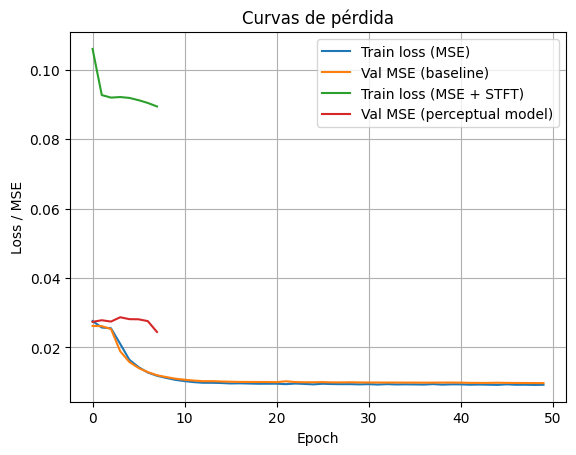

In [ ]:
# grafica de perdidas
plt.figure()
plt.plot(results_mse["train_losses"], label="Train (MSE)")
plt.plot(results_mse["val_mse"],      label="Val MSE (baseline)")

plt.plot(results_perc["train_losses"], label="Train (MSE + STFT)")
plt.plot(results_perc["val_mse"],      label="Val MSE (perceptual)")

plt.xlabel("Epoch")
plt.ylabel("Loss / MSE")
plt.legend()
plt.title("Curvas de pérdida (comparación en MSE)")
plt.grid(True)
plt.show()

# grafica extra: solo para ver STFT val del perceptual
if results_perc["val_stft"] is not None:
    plt.figure()
    plt.plot(results_perc["val_stft"], label="Val STFT (perceptual)")
    plt.xlabel("Epoch")
    plt.ylabel("STFT loss")
    plt.legend()
    plt.title("Curva STFT (solo modelo perceptual)")
    plt.grid(True)
    plt.show()

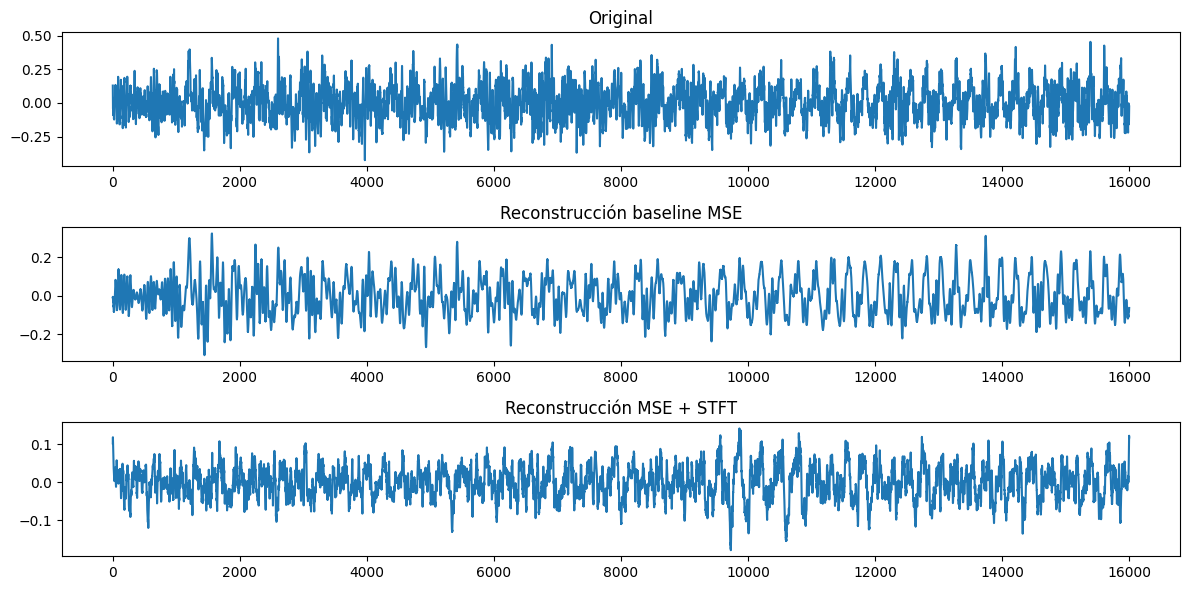

Original:


Recon (MSE):


Recon (MSE + STFT):


In [38]:
# ejemplo de reconstruccion
from IPython.display import Audio, display

batch = next(iter(test_loader))
x = batch["audio"][:4].float().to(device).unsqueeze(1)

model_mse.eval()
model_perc.eval()

with torch.no_grad():
    x_rec_mse, _ = model_mse(x)
    x_rec_perc, _ = model_perc(x)

# waveform original vs reconstruida
idx = 0
orig = x[idx].detach().cpu().squeeze().numpy()
rec_mse = x_rec_mse[idx].detach().cpu().squeeze().numpy()
rec_perc = x_rec_perc[idx].detach().cpu().squeeze().numpy()

plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(orig)
plt.title("Original")

plt.subplot(3, 1, 2)
plt.plot(rec_mse)
plt.title("Reconstrucción baseline MSE")

plt.subplot(3, 1, 3)
plt.plot(rec_perc)
plt.title("Reconstrucción MSE + STFT")
plt.tight_layout()
plt.show()

# reproducir audio (original vs reconstrucciones)
print("Original:")
display(Audio(orig, rate=SAMPLE_RATE))
print("Recon (MSE):")
display(Audio(rec_mse, rate=SAMPLE_RATE))
print("Recon (MSE + STFT):")
display(Audio(rec_perc, rate=SAMPLE_RATE))

# <h2 style="text-align: center; font-weight: bolder;">LONG AUDIOS STRATEGY</h2>


# <h2 style="text-align: center; font-weight: bolder;">RECONSTRUCTION IMPROVEMENT (PERCEPTUAL LOSS)</h2>


# <h2 style="text-align: center; font-weight: bolder;">RESULTS AND REPORT</h2>


In [ ]:
# resumen final de resultados y emisiones
def print_summary(name, res):
    print(f"=== {name} ===")

    # métrica comparable entre modelos
    if "val_mse" in res and res["val_mse"] is not None:
        print(f"Mejor Val MSE:  {min(res['val_mse']):.6f}")

    # métrica perceptual (solo aplica si existe)
    if "val_stft" in res and res["val_stft"] is not None:
        print(f"Mejor Val STFT: {min(res['val_stft']):.6f}")

    print(f"Tiempo total:  {res['time_min']:.2f} min")
    print(f"Emisiones CO₂ estimadas: {res['emissions_kg']:.6f} kg")
    print()

print_summary("Baseline MSE", results_mse)
print_summary("MSE + STFT",   results_perc)

=== Baseline MSE ===
Mejor MSE val: 0.009741
Tiempo total:  122.53 min
Emisiones CO₂ estimadas: 0.003910 kg

=== MSE + STFT ===
Mejor MSE val: 0.024468
Tiempo total:  21.13 min
Emisiones CO₂ estimadas: 0.000674 kg

